# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [127]:
!git clone -b develop https://github.com/kulaginv/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 523, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 523 (delta 10), reused 10 (delta 3), pack-reused 492
Receiving objects: 100% (523/523), 68.18 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [128]:
cd cvr_course/notebooks

/content/cvr_course/notebooks/cvr_course/notebooks/cvr_course/notebooks


In [129]:
import numpy as np
import cv2
import time
import os
import math
import sys
import glob
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

##Чтение изображений

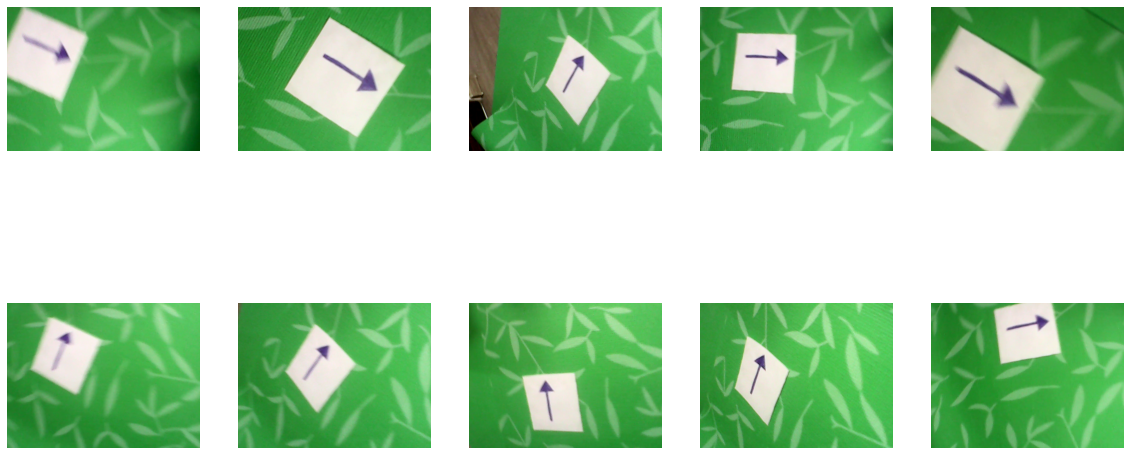

In [130]:
files = glob.glob('../data/imgs/arrow/*.png')
images = []
i = 1
for fname in files:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(2,5,i)
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.show()
    

##Нахождение расстояния 

In [131]:
def find_contour (img, low_th = (200, 200, 200), high_th = (255, 255, 255)):
    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.inRange (img, low_th, high_th)
    
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mx_area = 0
    for contour in contours:
      area = cv2.contourArea(contour)
      if area > mx_area:
        mx_area = area
        cnt = contour
    
    approx = cv2.convexHull (cnt)

    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)

    return approx

In [132]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour (img, low_th, high_th)
    
    length = cv2.arcLength (contour, True)

    distance = 180.0 * 364 / length
    
    return distance

In [133]:
for i in range(len(images)):
  print(find_distance(images[i]))

77.07543760345204
58.213898179172
91.934760625742
86.98571825076148
66.25763790351805
94.81533612993083
91.4181030090751
95.15204916054759
96.64850710230294
92.1951292094964


##Bиду сверху

In [134]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    pts=np.delete(pts,np.argmax(s),axis=0)
    s = pts.sum(axis=1)
    pts=np.delete(pts,np.argmin(s),axis=0)

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    
    return rect

In [135]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

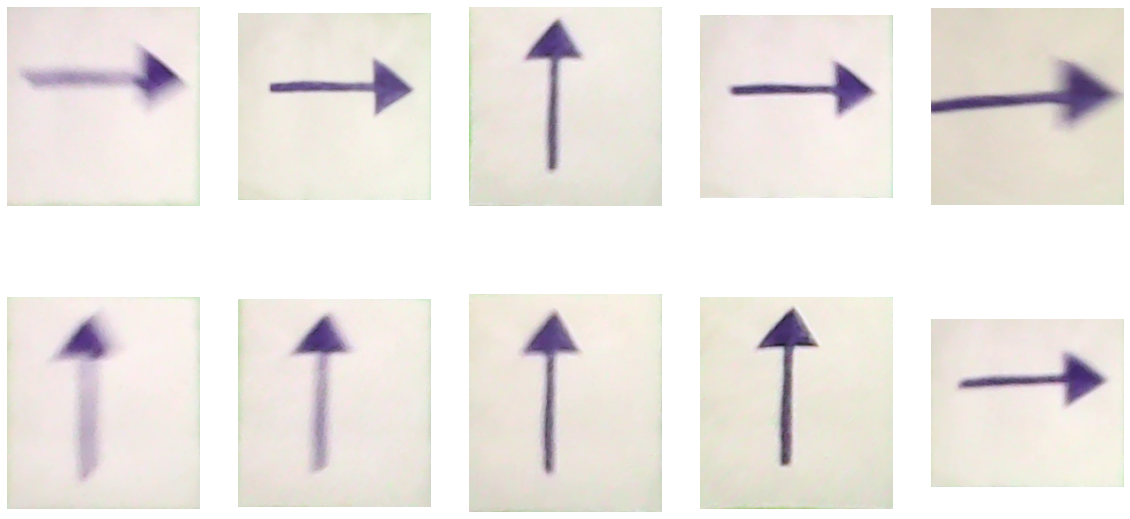

In [136]:
for i in range(len(images)):
  warped = four_point_transform (images[i], np.asarray(find_contour(images[i]))[:, 0, :])
  plt.subplot(2,5,i+1)
  plt.imshow(warped)
  plt.axis ('off')
plt.show ()

##Определение направления

In [271]:
def arrow_direction(img):
  high_th = (200, 200, 200)
  low_th = (0, 0, 0)

  #smooth_img = cv2.bilateralFilter(img, 15, 75, 75)
  mask = cv2.inRange(img, low_th, high_th)

  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  areas = []
  for contour in contours:
    areas.append(cv2.contourArea(contour))

  max_id = areas.index(max(areas))
  cnt = contours[max_id]

  M = cv2.moments(cnt)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  x, y, w, h = cv2.boundingRect(cnt)
  bbox = (x, y, w, h)

  if w < h:
    if cy - y > h // 2:
      arrow = 'down'
    else:
      arrow = 'up'
  else:
    if cx - x > w // 2:
      arrow = 'right'
    else:
      arrow = 'left'

  return arrow

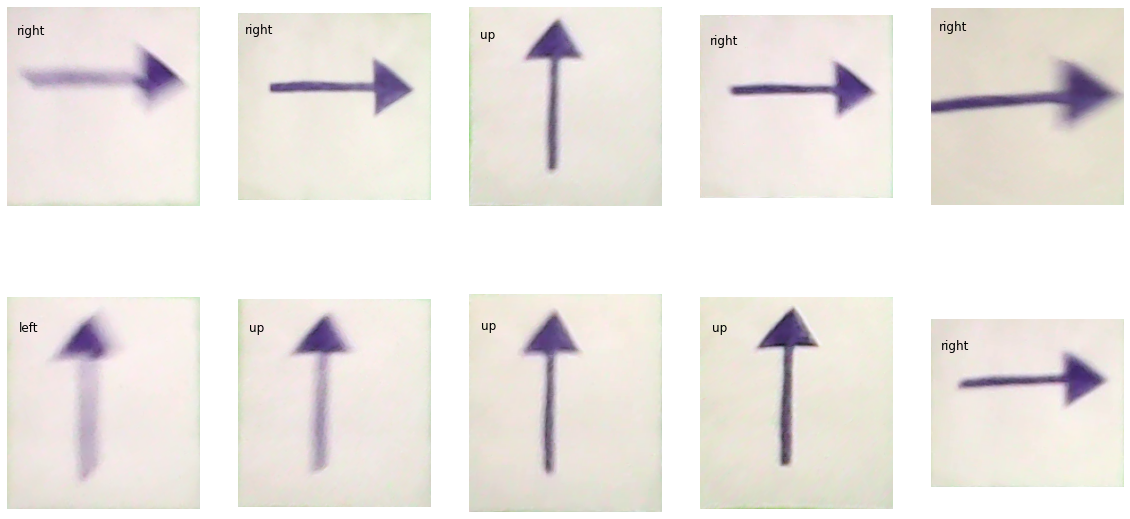

In [272]:
for i in range(len(images)):
  warped = four_point_transform (images[i], np.asarray(find_contour(images[i]))[:, 0, :])
  dir = arrow_direction(warped)
  plt.subplot(2,5,i+1)
  plt.imshow(warped)
  plt.text(10,30,dir,fontsize=12)
  plt.axis('off')
plt.show ()